# NBA Rebounding Evolution

The purpose of this project is to practice my SQL skills by evaluating how rebounding has evolved in the NBA, particularly from the Guard positions, which are usually the smallest players on the court. A [medium](https://medium.com/@davidve0206/evolution-of-nba-rebounding-b1aef152c715) blog post explains the narrative of the project, and this file acts just as the codebase behind the post.

The data used for the project comes from [this](https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats) dataset on Kaggle; as the datasets are provided as csv files, I created a simple SQLite database with the two files I am most interest in, Player Per Game and Team Summaries, which has been placed in this repository after creation.

Given this, we will first import all necessary libraries, including "SQL Magic" to run queries directly in the Notebook and connect to the created "nbadatabase".

In [8]:
import numpy as np
import pandas as pd
import plotly.express as px

#This is used for plotly figures to show on github, although they lose the characteristic interactivity
import plotly.io as pio
pio.renderers.default = "png"

%load_ext sql
%sql sqlite:///nbadatabase.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: @nbadatabase.sqlite'

This analysis is heavily centered around the division between the two types of positions in basketball: "Guards", who play the Point Guard or Shooting Guard positions, or "Bigs", players who play at the Forward or Center positions. We will first understand the positions registered in the players database.

In [9]:
%sql SELECT pos, COUNT(pos) FROM player_per_game_stats GROUP BY pos

 * sqlite:///nbadatabase.sqlite
Done.


pos,COUNT(pos)
C,5895
C-F,94
C-PF,41
C-SF,1
F,269
F-C,138
F-G,116
G,305
G-F,155
PF,6106


As the key stat we will be looking at is rebounds per game (trb_per_game), we will create a view in the database dropping any player that does not have a value in this category, so as to not have to add a subquery in every query. Additionally, we will cast the positions into a new variable that classifies player in one of two categories (for this, any player that has player the forward position is considered a Big; moreover, as most players are classified in a single position we will not be considering scenarios where one player has played as both a guard and a forward in separate seasons, this is a potential improvement to this step).

In [10]:
%%sql

DROP VIEW IF EXISTS player_stats_rebounds;

CREATE VIEW player_stats_rebounds AS
SELECT player, season, tm as team, trb_per_game, fga_per_game, fg_percent, x3pa_per_game, x3p_percent, pts_per_game,
    CASE
        WHEN pos LIKE '%G%' THEN 'Guard'
        WHEN pos LIKE '%F%' OR pos LIKE '%C%' THEN 'Big'
        ELSE 'Error'
        END  player_type
FROM player_per_game_stats
WHERE NOT trb_per_game = 'NA'

 * sqlite:///nbadatabase.sqlite
Done.
Done.


[]

In [11]:
%sql SELECT player_type, COUNT(player_type) FROM player_stats_rebounds GROUP BY player_type

 * sqlite:///nbadatabase.sqlite
Done.


player_type,COUNT(player_type)
Big,17947
Guard,12124


Now, lets start with the obvious, who are the all-time leaders in Rebound per Game across their career:

In [12]:
%%sql
SELECT player, player_type, PRINTF("%.2f", AVG(trb_per_game)) AS avg_rebounds
FROM player_stats_rebounds
GROUP BY player
ORDER BY AVG(trb_per_game) DESC
LIMIT 10

 * sqlite:///nbadatabase.sqlite
Done.


player,player_type,avg_rebounds
Wilt Chamberlain,Big,22.71
Bill Russell,Big,22.38
Maurice Stokes,Big,17.27
Bob Pettit,Big,16.11
Jerry Lucas,Big,15.08
Nate Thurmond,Big,13.96
Wes Unseld,Big,13.85
Mel Daniels,Big,13.69
Dennis Rodman,Big,13.37
Dave Cowens,Big,13.21


As is expected, the top rebounders are all Bigs. Nevertheless, lets check who the top rebounders at the Guard positions (Point Guard "PG" and Shooting Guard "SG") across their career are:

In [13]:
%%sql
SELECT player, player_type, PRINTF("%.2f", AVG(trb_per_game)) AS avg_rebounds
FROM player_stats_rebounds
WHERE player_type = 'Guard'
GROUP BY player
ORDER BY AVG(trb_per_game) DESC
LIMIT 10

 * sqlite:///nbadatabase.sqlite
Done.


player,player_type,avg_rebounds
Luka Dončić,Guard,8.64
Tom Gola,Guard,8.09
Ndudi Ebi,Guard,8.00
Josh Giddey,Guard,8.00
Ben Simmons,Guard,7.68
Oscar Robertson,Guard,7.42
Russell Westbrook,Guard,7.33
Magic Johnson,Guard,7.33
Jerry Sloan,Guard,7.21
Giannis Antetokounmpo,Guard,7.20


As expected, the top rebounders in the position have significantly lower rebound counts than their "big" counterparts, but we can also see there is a mix of both recent players (like Luka, Simmons and Westbrook) with older players (Robertson, Johnson). Moreover, we can see Giannis, who plays PF most of the time, was listed in two seasons as PG and SG and cracked the TOP-10 (we could fix this by joining the table with a career-long position table, but for now we will leave it as it is).

Given this, we will explore the distribution of rebounds per game across positions; as SQLite does not provide a Standard Deviation function, we will be using a box plot.

In [14]:
rebounds_df = %sql SELECT player, player_type, trb_per_game, season FROM player_stats_rebounds
rebounds_df = rebounds_df.DataFrame()
rebounds_df['season'] = pd.to_numeric(rebounds_df['season'])
rebounds_df['trb_per_game'] = pd.to_numeric(rebounds_df['trb_per_game'])
rebounds_df.dtypes

 * sqlite:///nbadatabase.sqlite
Done.


player           object
player_type      object
trb_per_game    float64
season            int64
dtype: object

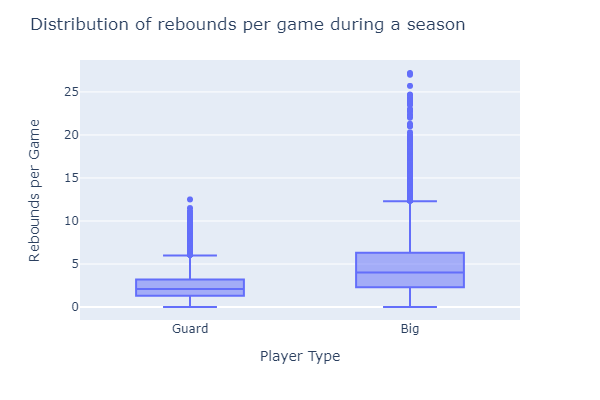

In [15]:
fig = px.box(rebounds_df, x='player_type', y='trb_per_game', hover_data=['player', 'season'])
fig.update_layout(title="Distribution of rebounds per game during a season",
                width=600, height=400,
                xaxis_title='Player Type',
                yaxis_title='Rebounds per Game')
fig.show()

As expected, the distribution of player rebounds is "shorter" for Guards, but both distributions have a large number of outliers (NBA's all time greats). Now we will see how these rebounds per game have evolved over time:

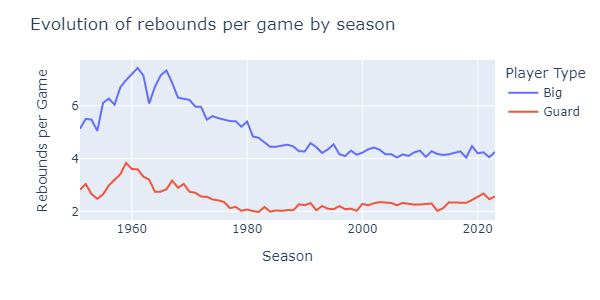

In [16]:
avg_per_season = rebounds_df[['season','player_type','trb_per_game']].groupby(['season', 'player_type']).mean(numeric_only=True).reset_index()

fig = px.line(avg_per_season, x='season', y='trb_per_game', color='player_type')
fig.update_layout(title="Evolution of rebounds per game by season",
                width=600, height=300,
                xaxis_title='Season',
                yaxis_title='Rebounds per Game',
                legend_title='Player Type')
fig.show()

The results are not what I expected; as I had assumed rebounds would be higher in recent years, so I decided to check wether some other variables correlated with the ammount of rebounds per game, which we will do graphically:

In [17]:
%%sql per_season_stats << SELECT AVG(trb_per_game) as rebounds, AVG(fga_per_game) as field_goal_attempts, AVG(fg_percent) as field_goal_perc,
                                AVG(x3pa_per_game) as three_point_attempts, AVG(x3p_percent) as three_point_perc, AVG(pts_per_game) as points, season
                            FROM player_stats_rebounds
                            GROUP BY season

 * sqlite:///nbadatabase.sqlite
Done.
Returning data to local variable per_season_stats


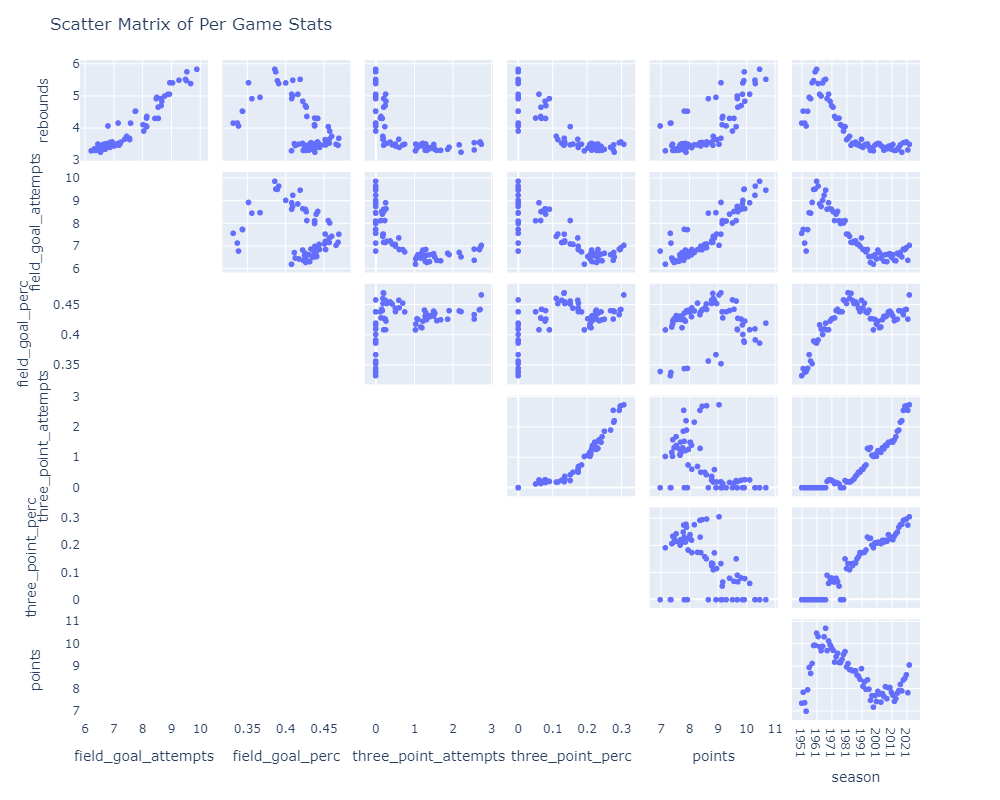

In [18]:
per_season_stats_df = per_season_stats.DataFrame()
fig = px.scatter_matrix(per_season_stats_df, hover_data=['season'])
fig.update_layout(title='Scatter Matrix of Per Game Stats',
                  width=1000,
                  height=800)
fig.update_traces(diagonal_visible=False,
                  showlowerhalf=False)
fig.show()

The previous result shows that average rebounds are highly correlated to the pace of the game, which has significantly higher in the early years of the NBA; this made me realize that the variable that I should be reviewing was not the average rebounds of each position. The value to understand if the 3-point revolution has affected the rebounding from Guards is the difference between rebounds by Bigs and the average rebounds by Guards.

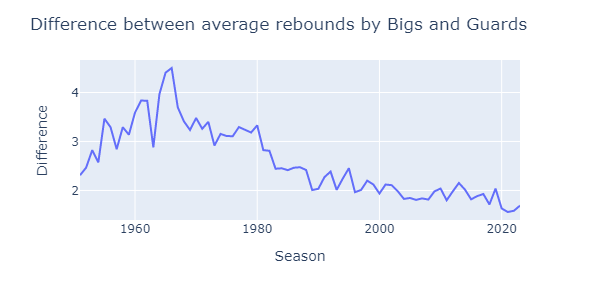

In [19]:
#Creates a new dataframe containing the difference between the average rebounds for bigs and guards for each season, then graphs the results
seasons = list(avg_per_season['season'].unique())
differences = []

for season in seasons:
    differences.append(avg_per_season.loc[(avg_per_season['season'] == season) & (avg_per_season['player_type'] == 'Big'), 'trb_per_game'].values[0]
                                - avg_per_season.loc[(avg_per_season['season'] == season) & (avg_per_season['player_type'] == 'Guard'), 'trb_per_game'].values[0])
season_diff_df = pd.DataFrame({'season': seasons, 'avg_rb_diff': differences})
season_diff_df.head()

fig = px.line(season_diff_df, x='season', y='avg_rb_diff')
fig.update_layout(title="Difference between average rebounds by Bigs and Guards",
                width=600, height=300,
                xaxis_title='Season',
                yaxis_title='Difference')
fig.show()

As we can see, the difference in average rebounds by Bigs and Guards has decreased over time, and is currently at an all-time-low of only 1.5 rebounds per game! So this concludes the EDA stage of this project.